In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable
from epi.util import plot_T_x


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"

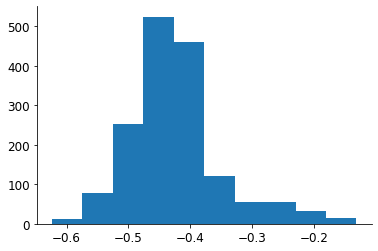

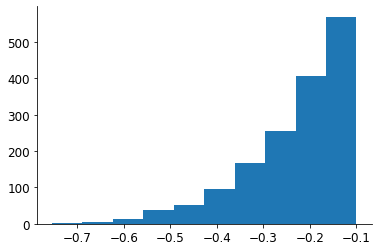

inds [ 483 1070  999 1216 1322  217 1097  993  699 1474]
[-0.5189938 +0.j       -0.49519464+0.j       -0.47821099+0.j
 -0.46390704+0.j       -0.50391012+0.j       -0.75393445+0.033136j]


In [2]:
from scipy.io import loadmat 
import os
matfile = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))
maxE = matfile['maxE']
plt.figure()
plt.hist(np.real(maxE[:,0]))
plt.show()

plt.figure()
plt.hist(np.real(maxE[:,-1]))
plt.show()

inds = np.argsort(maxE[:,-1])
print('inds', inds[:10])
print(maxE[inds[0]])


In [3]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [4]:
ind = 1070
HB = load_SSSN_variable('hb', ind=ind)
HC = load_SSSN_variable('hc', ind=ind)
print('hb', HB)
print('hc', HC)

lb = -0.5*np.ones((4,))
ub = 0.5*np.ones((4,))
dh = Parameter("dh", 4, lb=lb, ub=ub)
parameters = [dh]

# Define model
name = "SSSN"
model = Model(name, parameters)


hb tf.Tensor([0.590407   0.50438005 0.5148208  0.6697344 ], shape=(4,), dtype=float32)
hc tf.Tensor([0.594786 0.396027 0.       0.      ], shape=(4,), dtype=float32)


V: 30 510/500
V: 30 505/500


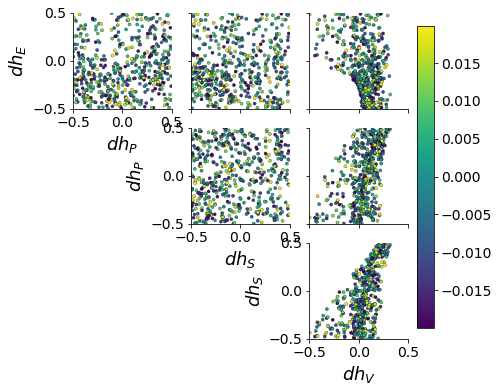

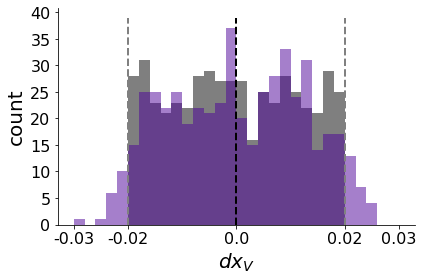

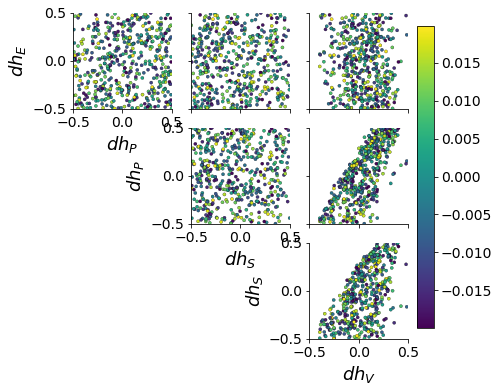

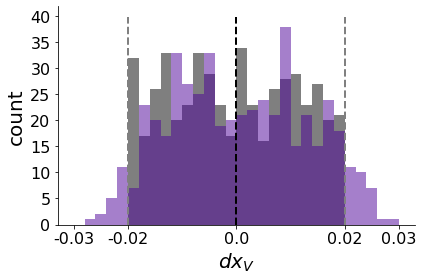

In [9]:
D = 4
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < 2*inc_std)

alphas = ['V']
num_alphas = len(alphas)
num_keep = 500
num_plot = 500
M = 1000
zs = []
T_xs = []

inc_std = 0.01
contrasts = [0.]
contrasts = [0.,1.]

for contrast in contrasts:
    H = HB + contrast*HC
    h = tf.constant(H[None,:], dtype=tf.float32)
    def dr(dh):
        x1 = tf.reduce_mean(SSSN_sim(h)[:,:,:4], axis=1)
        x2 = tf.reduce_mean(SSSN_sim(h + dh)[:,:,:4], axis=1)

        diff = x2 - x1
        T_x = tf.concat((diff, diff ** 2), axis=1)

        return T_x
    
    model.set_eps(dr)
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        name = "V1_Circuit_%s_c=%.1f" % (alpha, contrast)
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()
            #print('min', np.min(_T_x[:,0]))
            #print('max', np.max(_T_x[:,0]))

            inds = accept_inds(_T_x, alpha, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        _dv = T_x[:,neuron_ind]
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                       fontsize=18, lb=lb, ub=ub, c=_dv)
        plt.savefig(figdir + name + '_ABC_z.png')
        
        T_x_sim = model.eps(z).numpy()
        
        plot_T_x(T_x[:,neuron_ind], T_x_sim[:,neuron_ind], x_mean=0., x_std=inc_std, xmin=-3*inc_std, xmax=3.*inc_std, xlabel=r'$dx_%s$' % alpha, fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_Tx.png')
        print('')
        
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)

In [7]:
"""num_plot = 500
fontsize = 14
z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
fig = pairplot(z[:num_plot], np.arange(4), z_labels,
               fontsize=22,
               lb=lb, ub=ub)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')"""

"num_plot = 500\nfontsize = 14\nz_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']\nfig = pairplot(z[:num_plot], np.arange(4), z_labels,\n               fontsize=22,\n               lb=lb, ub=ub)\nplt.savefig(figdir + 'SV_flip_ABC_z.png')\n               #c_label='prod')"

(500, 1, 8, 101)


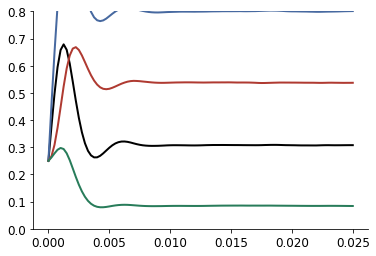

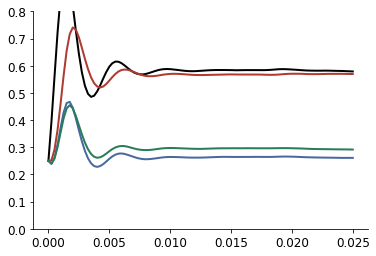

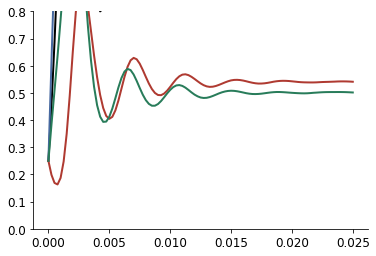

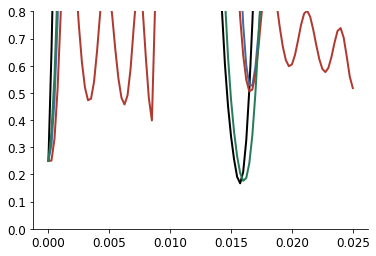

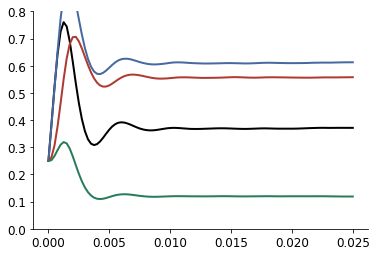

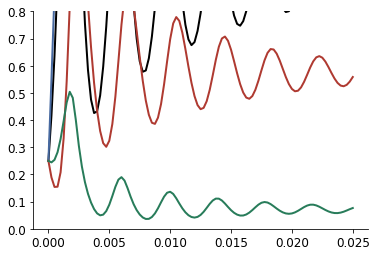

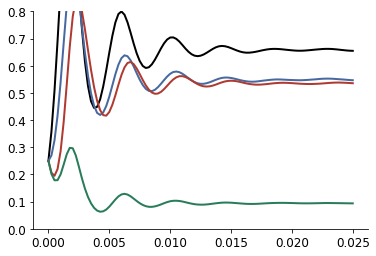

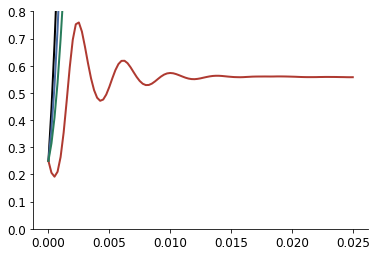

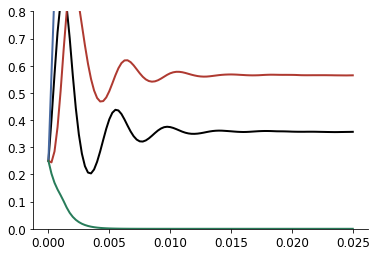

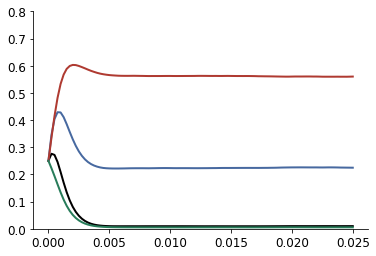

In [8]:
hs = z + H
x_t = SSSN_sim_traj(hs).numpy()
print(x_t.shape)
dt = 0.00025
t = dt*np.arange(101)
for j in range(10):
    plt.figure()
    for i in range(4):
        plt.plot(t, x_t[j,0,i,:].T, c=colors[i])
    plt.ylim([0, .8])
    plt.show()